## Stability Testing of Optimization
In this notebook we cover how to test the stability of the optimal readout pulse waveforms generated with respect to system parameters such as the kappa and chi.

In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax import jit, vmap, block_until_ready, config

from algos.ppo import PPO_make_train

In [2]:
# Seeding all Random Number Generation during the RL Training for Reproducibility

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [3]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 25.0
chi = 0.65
kerr = 0.002
gamma = 1/100
time_coeff = 10.0
snr_coeff = 10.0
rough_max_photons = 31
rough_max_amp_scaled = 1/0.43
actual_max_photons = rough_max_photons * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {rough_max_photons}")
print(f"Actual Max Photons: {actual_max_photons}")
ideal_photon = 1e-2
scaling_factor = 7.5
gamma_I = 1/500
num_t1 = 8.0
photon_gamma = 1/2000
init_fid = 1 - 1e-3

batchsize = 64
num_envs = 8
num_updates = 1000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 256,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": False,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 31
Actual Max Photons: 30.573151382405857


In [4]:
num_exp = 3
batch_rng = jax.random.split(_rng, num_exp)
rng, _rng = jax.random.split(rng)

ones_arr = np.ones(num_exp)

kappa_vals = np.array([kappa * (1 - 0.1), kappa, kappa * (1 + 0.1)])
chi_vals = chi * ones_arr
kerr_vals = kerr * ones_arr
gamma_vals = gamma * ones_arr
time_coef_vals = time_coeff * ones_arr
snr_coef_vals = snr_coeff * ones_arr
rough_max_photons_vals = rough_max_photons * ones_arr
actual_max_photons_vals = actual_max_photons * ones_arr
rough_max_amp_scaled_vals = rough_max_amp_scaled * ones_arr
ideal_photon_vals = ideal_photon * ones_arr
scaling_factor_vals = scaling_factor * ones_arr
gamma_I_vals = gamma_I * ones_arr
num_t1_vals = num_t1 * ones_arr
photon_gamma_vals = photon_gamma * ones_arr
init_fid_vals = init_fid * ones_arr

In [5]:
vmap_index_list = np.zeros(16, dtype=np.int8).tolist() + [None] * 2

multi_kappa_train = jit(
    vmap(PPO_make_train(config), in_axes=vmap_index_list), 
    static_argnums=(-2, -1)
)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
multi_kappa_result = multi_kappa_train(
    batch_rng, 
    kappa_vals, 
    chi_vals, 
    kerr_vals,
    gamma_vals,
    time_coef_vals,
    snr_coef_vals,
    rough_max_photons_vals,
    actual_max_photons_vals,
    rough_max_amp_scaled_vals,
    ideal_photon_vals,
    scaling_factor_vals,
    gamma_I_vals,
    num_t1_vals,
    photon_gamma_vals,
    init_fid_vals,
    batchsize, 
    num_envs)
print(f"time taken: {time.time() - start}")

Starting a Run of 1000 Updates


In [30]:
# Extracting Results

metrics = multi_kappa_result["metrics"]

max_actions = metrics["action of max"]
max_rewards = metrics["max reward obtained"]
max_photons = metrics["photon at max"]
max_pFs = metrics["pF at max"]
max_times = metrics["photon time of max"]
mean_rewards = metrics["mean batch reward"]
mean_pFs = metrics["mean batch pF"]
mean_photons = metrics["mean batch photon"]
mean_photon_times = metrics["mean batch photon time"]

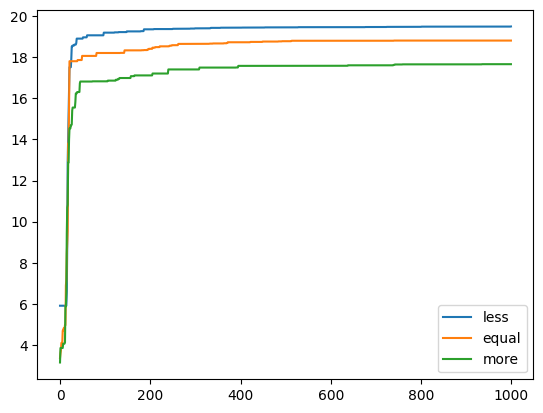

In [34]:
plt.plot(max_rewards[0,:,-1], label='less')
plt.plot(max_rewards[1,:,-1], label='equal')
plt.plot(max_rewards[2,:,-1], label='more')
plt.legend()
plt.show()

In [1]:
from jax.numpy import diff
from jax.scipy.integrate import trapezoid

ts = jnp.linspace(0., 1/kappa * num_t1, 121)

def t1_duration(kappa, res_scale_factor, tau_0):
    return (
        -2
        / kappa
        * jnp.log(1 - 1 / res_scale_factor * (1.0 - jnp.exp(-0.5 * kappa * tau_0)))
    )


def t3_duration(kappa, res_scale_factor):
    return -2 / kappa * jnp.log(res_scale_factor / (1.0 + res_scale_factor))

def ph(x):
    return -jnp.log(1 - x)

first_segment = t1_duration(kappa_vals, rough_max_amp_scaled, tau_0=tau_0)
third_segment = t3_duration(kappa_vals, rough_max_amp_scaled)

t2_vals = [0.21, 0.2, 0.2]

ind = 6

fig, ax = plt.subplots(3, figsize=(10.0, 16.0))

dx = ts[1] - ts[0]
usable_ts = ts[1:-1]
print(len(usable_ts))

first_deriv = jnp.diff(max_actions[0, -1, ind]) / dx
ax[0].plot(ts, first_deriv)
second_deriv = (jnp.diff(first_deriv) / dx) ** 2
first_smoothness = trapezoid(second_deriv, usable_ts, dx=dx) / dx
print(f"First Smoothness: {first_smoothness}")

first_deriv = jnp.diff(max_actions[1, -1, ind]) / dx
second_deriv = (jnp.diff(first_deriv) / dx) ** 2
second_smoothness = trapezoid(second_deriv, usable_ts, dx=dx) / dx
print(f"Second Smoothness: {second_smoothness}")

first_deriv = jnp.diff(max_actions[2, -1, ind]) / dx
second_deriv = (jnp.diff(first_deriv) / dx) ** 2
third_smoothness = trapezoid(second_deriv, usable_ts, dx=dx) / dx
print(f"Third Smoothness: {third_smoothness}")

ax[0].plot(ts, max_actions[0, -1, ind], label='less')
ax[0].set_xlabel('time (us)')
ax[0].set_ylabel('amplitude (A.U.)')
ax[0].set_title('10 percent less kappa')
ax[0].axvline(x=first_segment[0], color='black', label='t1')
ax[0].axvline(x=t2_vals[0], color='orange', label='t2')
ax[0].axvline(x=t2_vals[0] + third_segment[0], color='red', label='t3')
ax[0].axhline(y=0, linestyle='dashed', color='grey')
ax[0].legend()

ax[1].plot(ts, max_actions[1, -1, ind], label='equal')
ax[1].set_xlabel('time (us)')
ax[1].set_ylabel('amplitude (A.U.)')
ax[1].set_title('equal kappa')
ax[1].axvline(x=first_segment[1], color='black', label='t1')
ax[1].axvline(x=t2_vals[1], color='orange', label='t2')
ax[1].axvline(x=t2_vals[1] + third_segment[1], color='red', label='t3')
ax[1].axhline(y=0, linestyle='dashed', color='grey')
ax[1].legend()

ax[2].plot(ts, -max_actions[2, -1, ind], label='more')
ax[2].set_xlabel('time (us)')
ax[2].set_ylabel('amplitude (A.U.)')
ax[2].set_title('10 percent more kappa')
ax[2].axvline(x=first_segment[2], color='black', label='t1')
ax[2].axvline(x=t2_vals[2], color='orange', label='t2')
ax[2].axvline(x=t2_vals[2] + third_segment[2], color='red', label='t3')
ax[2].axhline(y=0, linestyle='dashed', color='grey')
ax[2].legend()

plt.show()

NameError: name 'jnp' is not defined

87.8s for 100 updates
151.8s for 200 updates

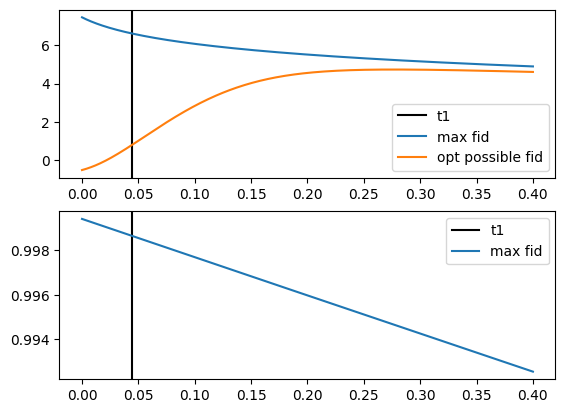

In [76]:
from jax.scipy.integrate import trapezoid
from jax.scipy.special import erf

def fidelity_curves(
    kappa,
    chi,
    N0,
    res_scale_factor,
    tau_0,
    init_fid,
    gamma_M,
    b,
    mu_s
):
    ts = jnp.linspace(0., 10. / kappa, 401)
    t1 = t1_duration(kappa, res_scale_factor, tau_0)
    factor = 1 - jnp.exp(-0.5*kappa*tau_0)

    ts_particular = jnp.linspace(0., t1, 401)
    high_photons = N0 * res_scale_factor ** 2 * (1 - np.exp(-0.5 * kappa * ts_particular))**2
    integral_val = trapezoid(gamma_M + b * high_photons, ts_particular, dx=0.0001)
    high_fidelity = init_fid * np.exp(-integral_val)

    fidelity_i2 = high_fidelity * jnp.exp(-(gamma_M + b * N0 * factor**2) * (ts - t1))
    
    B1 = res_scale_factor * ( chi/kappa * (1 - jnp.exp(-0.5 * kappa * t1)) - 0.5 * chi * t1 * jnp.exp(-0.5 * kappa * t1) ) / factor

    separation_77 = 2 * jnp.sqrt(N0) * factor * (
        jnp.exp(-0.5 * kappa * (ts - t1)) * B1 + chi / kappa * (1 - jnp.exp(-0.5 * kappa * (ts - t1)))
    )

    full_fidelity = erf(mu_s * separation_77) * fidelity_i2

    fig, ax = plt.subplots(2)

    ax[0].axvline(x=t1, label='t1', color='black')
    ax[0].plot(ts, ph(fidelity_i2), label='max fid')
    ax[0].plot(ts, ph(full_fidelity), label='opt possible fid')
    ax[0].legend()

    ax[1].axvline(x=t1, label='t1', color='black')
    ax[1].plot(ts, fidelity_i2, label='max fid')
    # ax[1].plot(ts, full_fidelity, label='opt possible fid')
    ax[1].legend()

    plt.show()

fidelity_curves(
    kappa=kappa,
    chi=chi,
    N0=rough_max_photons,
    res_scale_factor=rough_max_amp_scaled,
    tau_0=tau_0,
    init_fid=init_fid,
    gamma_M=gamma_I,
    b=photon_gamma,
    mu_s=scaling_factor
)